### Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

### Import data

In [4]:
df = pd.read_csv("final_converted.csv", sep="\t")
# df = df[df["view"] > 1e6]
# len(df)
print(df.columns)
df.head()

Index(['track', 'track_id', 'artist', 'album', 'sp_release_date', 'duration',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'playcount', 'video_id', 'view', 'channelTitle',
       'yt_release_date', 'title', 'genres'],
      dtype='object')


,track,track_id,artist,album,sp_release_date,duration,explicit,danceability,energy,key,...,valence,tempo,time_signature,playcount,video_id,view,channelTitle,yt_release_date,title,genres
0,Shape of You,0FE9t6xYkqWXU2ahLh6D8X,Ed Sheeran,Shape of You,2017-01-06,234,False,0.825,0.652,C♯,...,0.931,95.977,4/4,2971854102,JGwWNGJdvx8,5533840092,Ed Sheeran,2017-01-30T10:57:50Z,Ed Sheeran - Shape of You (Official Music Video),"pop,dancehall,tropical house"
1,Blinding Lights,0sf12qNH5qcw8qpgymFOqD,The Weeknd,Blinding Lights,2019-11-29,202,False,0.513,0.796,C♯,...,0.345,171.017,4/4,2636804603,fHI8X4OXluQ,611764719,TheWeekndVEVO,2019-11-29T05:00:08Z,The Weeknd - Blinding Lights (Official Audio),"synthwave,synth-pop,electropop"
2,Dance Monkey,5ZULALImTm80tzUbYQYM9d,Tones And I,The Kids Are Coming,2019-08-29,209,False,0.824,0.588,F♯,...,0.513,98.027,4/4,2407586466,q0hyYWKXF0Q,1732473790,Tones And I,2019-06-24T22:01:36Z,TONES AND I - DANCE MONKEY (OFFICIAL VIDEO),electropop
3,rockstar,7wGoVu4Dady5GV0Sv4UIsx,Post Malone,rockstar,2017-09-15,218,True,0.577,0.522,F,...,0.119,159.772,4/4,2299920941,UceaB4D0jpo,930777018,PostMaloneVEVO,2017-11-22T05:00:01Z,Post Malone - rockstar ft. 21 Savage,"cloud rap,trap"
4,One Dance,1xznGGDReH1oQq0xzbwXa3,Drake,Views,2016-05-06,174,False,0.791,0.619,C♯,...,0.371,103.989,4/4,2169189786,iAbnEUA0wpA,125034981,Chris Obando,2018-10-30T17:26:40Z,One Dance-Drake (feat. Wizkid &amp; Kyla),"dancehall,afrobeats,pop,uk funky"


### Plot correlation between each numeric variable and playcount and view

<AxesSubplot:ylabel='type'>

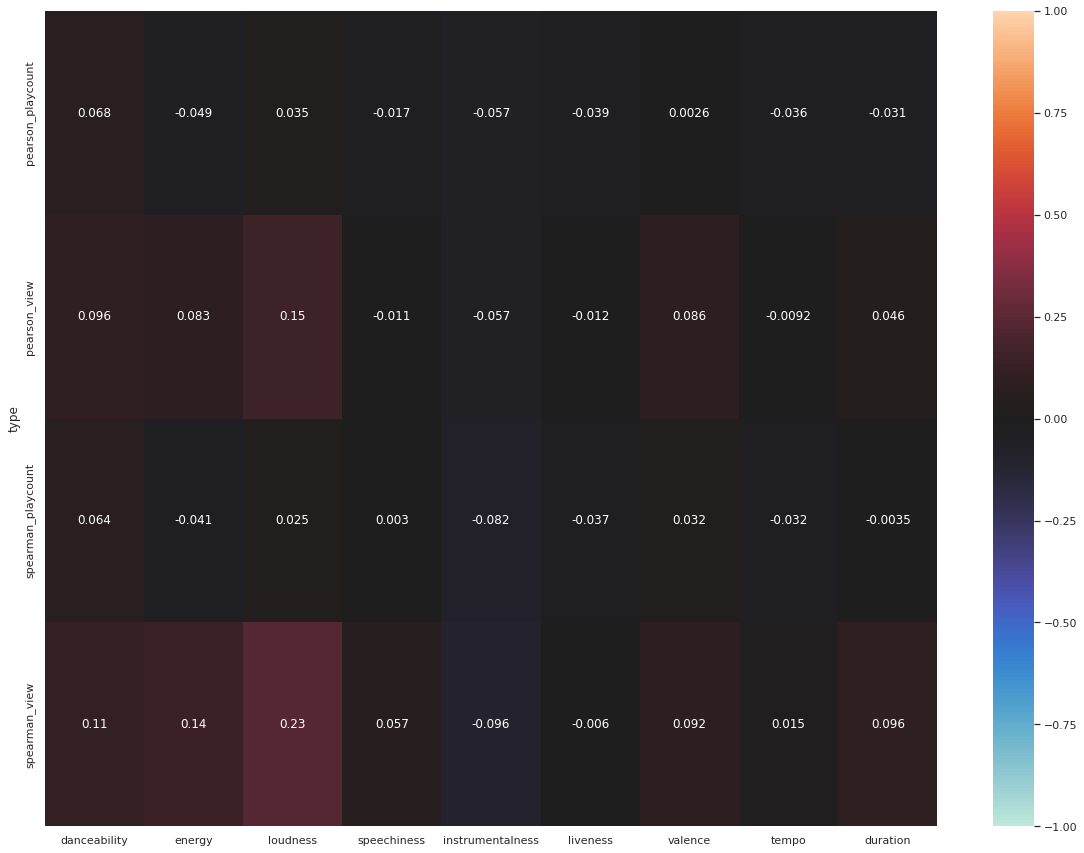

In [5]:
pearson_view = {}
pearson_playcount = {}
spearman_view = {}
spearman_playcount = {}
feature = ['danceability', 'energy', 'loudness',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']

for col in feature:
	pearson_playcount[col] = df['playcount'].corr(df[col], method='pearson')
	pearson_view[col] = df['view'].corr(df[col], method='pearson')
	spearman_view[col] = df['view'].corr(df[col], method='spearman')
	spearman_playcount[col] = df['playcount'].corr(df[col], method='spearman')

corr = pd.DataFrame(columns=feature)
corr = corr.append(pearson_playcount, ignore_index=True)
corr = corr.append(pearson_view, ignore_index=True)
corr = corr.append(spearman_playcount, ignore_index=True)
corr = corr.append(spearman_view, ignore_index=True)
corr['type'] = ['pearson_playcount', 'pearson_view', 'spearman_playcount', 'spearman_view']
corr = corr.set_index("type")

plt.figure(figsize=(20,15))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0)

### Plot distributrion and basic statistics

In [16]:
stat_dict = {}
for f in feature:
    stat_dict[f] = {}

for f in feature:
    mean = df[f].mean(axis = 0)
    stat_dict[f]['mean'] = mean
    #print(mean)
    variance = df[f].var(axis = 0)
    stat_dict[f]['variance'] = variance
    #print(variance)
    skewness = df[f].skew(axis = 0)
    stat_dict[f]['skewness'] = skewness
    #print(skewness)
    kurtosis = df[f].kurt(axis = 0)
    stat_dict[f]['kurtosis'] = kurtosis
    

    #print(kurtosis)

In [17]:
stat_dict

{'danceability': {'mean': 0.6445952808988765,
  'variance': 0.02303677323014135,
  'skewness': -0.4226081895655336,
  'kurtosis': -0.2040372673400319},
 'energy': {'mean': 0.666217191011236,
  'variance': 0.03244375571474211,
  'skewness': -0.5869892476266748,
  'kurtosis': -0.01880509691390575},
 'loudness': {'mean': -6.3965148314606735,
  'variance': 7.470373592609827,
  'skewness': -1.5692200009326622,
  'kurtosis': 5.070683773633162},
 'speechiness': {'mean': 0.09945355056179776,
  'variance': 0.009321166340503735,
  'skewness': 2.1340124772589135,
  'kurtosis': 5.134793609608989},
 'instrumentalness': {'mean': 0.0203947591752809,
  'variance': 0.01040624358970532,
  'skewness': 6.442514993396072,
  'kurtosis': 43.926240760076524},
 'liveness': {'mean': 0.17848341573033707,
  'variance': 0.019738732496309485,
  'skewness': 2.208640265750662,
  'kurtosis': 5.891380371351641},
 'valence': {'mean': 0.5068149438202247,
  'variance': 0.05272177941475297,
  'skewness': 0.0579468709810946

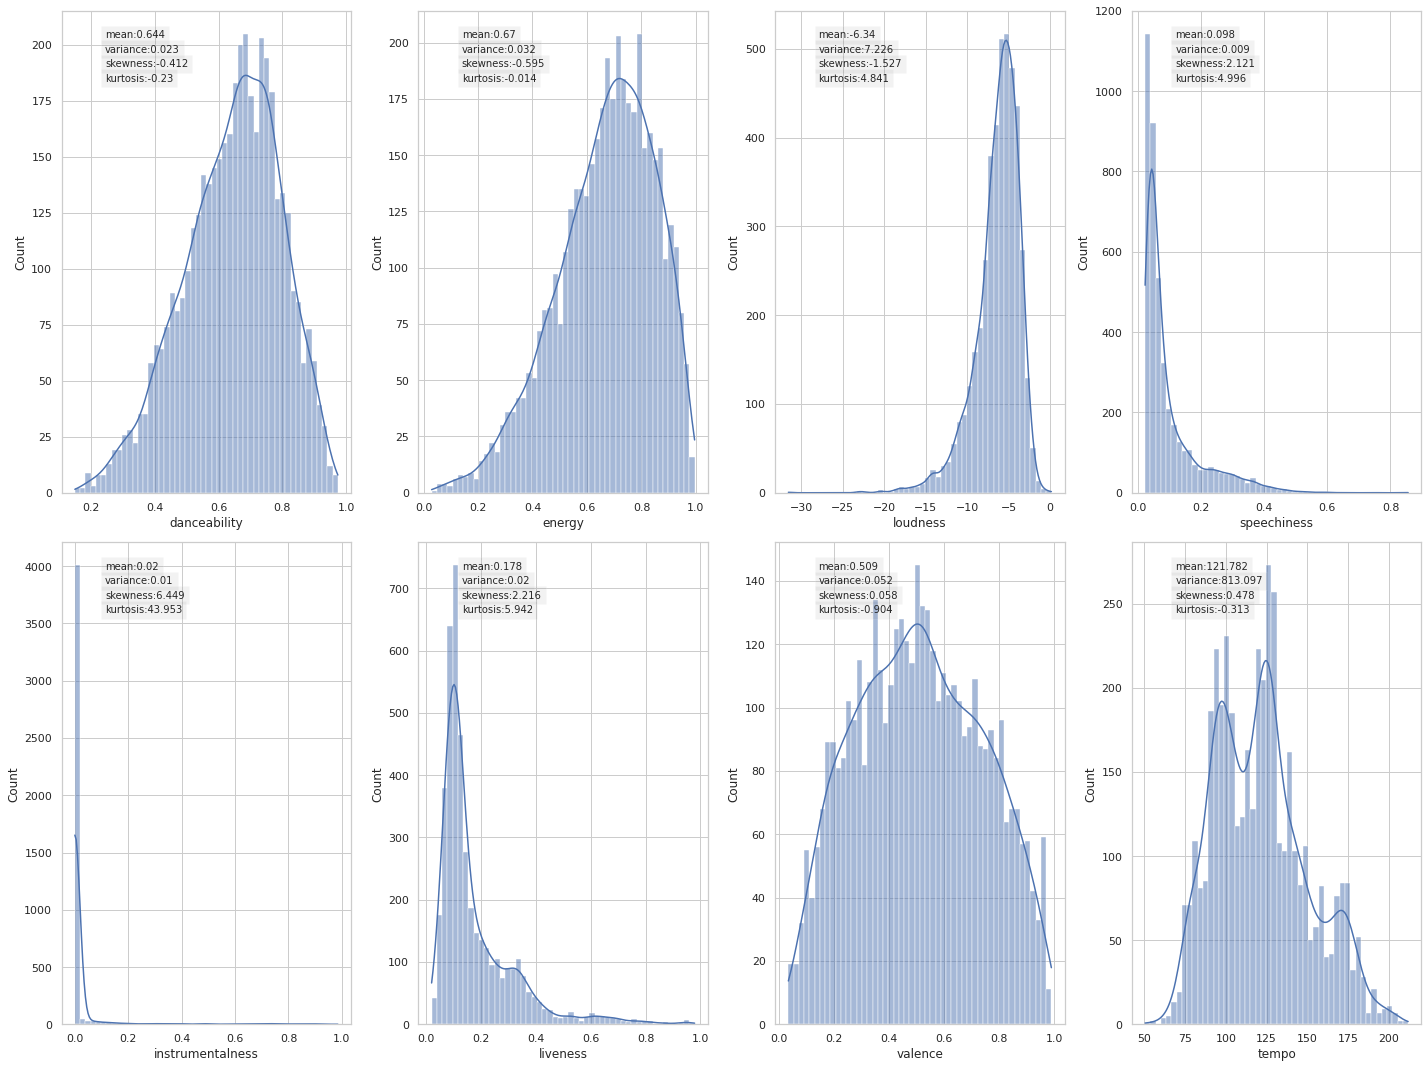

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for i in range(len(feature)):
    if i < 4:
        row = 0
    else:
        row = 1
    col = i % 4
    for j, key in enumerate(stat_dict[feature[i]].keys()):
        ax[row, col].text(0.15, 0.95 - j * 0.03, '{}:{}'.format(key, round(stat_dict[feature[i]][key], 3)), size=10,
                          verticalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='grey', alpha=0.1))
    sns.histplot(data=df, x=feature[i], ax=ax[row, col], kde=True, bins=50)
fig.tight_layout()


### Correlation between playcount and view

In [12]:
df['playcount'].corr(df['view'], method='spearman')

0.5575112979212782

<AxesSubplot:xlabel='playcount', ylabel='view'>

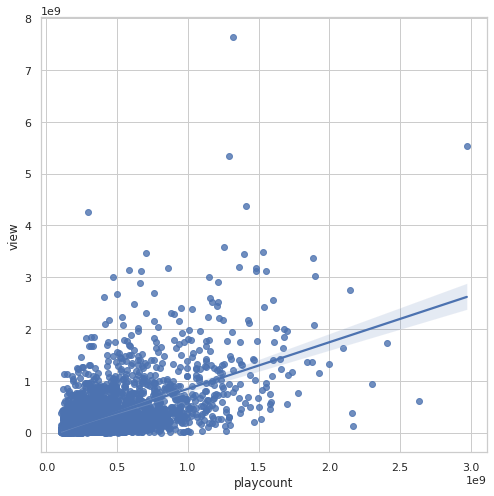

In [13]:
f, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x="playcount", y="view", ax=ax)

### Counts of each mode with different playcount bins

#### Shitty population pyramid

In [79]:
bins = pd.IntervalIndex.from_tuples([(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
df["bins"] = pd.cut(df["playcount"], bins)

In [84]:
pop_dist_0 = df[df["mode"] == 0].groupby("bins")[["playcount"]].count()
pop_dist_1 = df[df["mode"] == 1].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["0"] = pop_dist_0['playcount']
pop_dist["1"] = pop_dist_1['playcount'].apply(lambda x: 0 - x)
pop_dist = pop_dist.reset_index()

In [85]:
pop_dist

,bins,0,1
0,"(0.0, 200000000.0]",636,-926
1,"(200000000.0, 300000000.0]",393,-662
2,"(300000000.0, 400000000.0]",228,-347
3,"(400000000.0, 500000000.0]",157,-233
4,"(500000000.0, 750000000.0]",175,-288
5,"(750000000.0, 1000000000.0]",91,-124
6,"(1000000000.0, 3000000000.0]",82,-108


Text(0.5, 0, 'bruh')

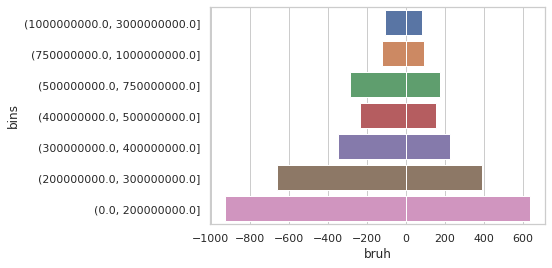

In [86]:
sns.barplot(x="0", y="bins", data=pop_dist, order=bins[::-1])
sns.barplot(x="1", y="bins", data=pop_dist, order=bins[::-1])
plt.xlabel("bruh")

#### Epic looking lollipop plot

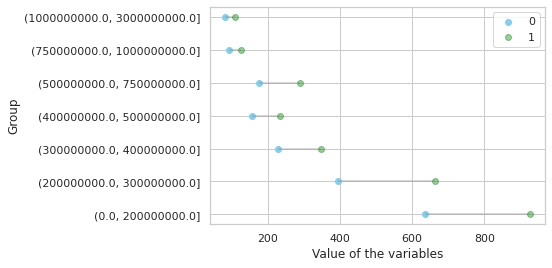

In [88]:
pop_dist_0 = df[df["mode"] == 0].groupby("bins")[["playcount"]].count()
pop_dist_1 = df[df["mode"] == 1].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["0"] = pop_dist_0['playcount']
pop_dist["1"] = pop_dist_1['playcount']
pop_dist = pop_dist.reset_index()
my_range=range(1,len(pop_dist.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=pop_dist['0'], xmax=pop_dist['1'], color='grey', alpha=0.4)
plt.scatter(pop_dist['0'], my_range, color='skyblue', alpha=1, label='0')
plt.scatter(pop_dist['1'], my_range, color='green', alpha=0.4 , label='1')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, pop_dist['bins'])
plt.xlabel('Value of the variables')
plt.ylabel('Group')

# Show the graph
plt.show()

### Scatter plot of view and playcount corresponding to the explicit variable

explicit
False    3166
True     1284
Name: track_id, dtype: int64


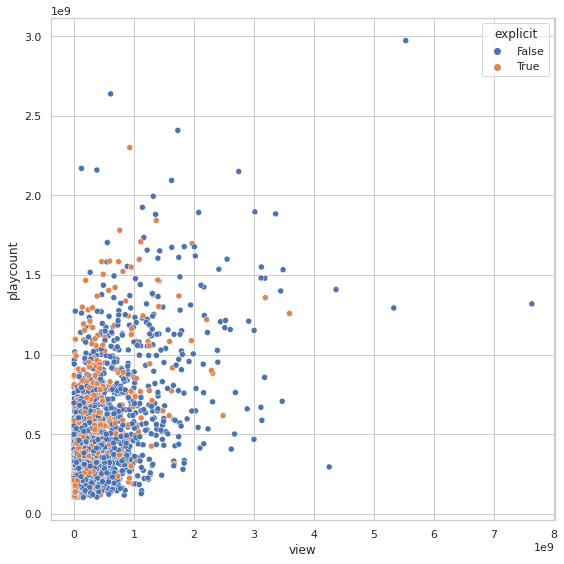

In [7]:
print(df.groupby('explicit')['track_id'].count())
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
f.tight_layout()

### Strip plot of the playcount of each key

<AxesSubplot:xlabel='key', ylabel='playcount'>

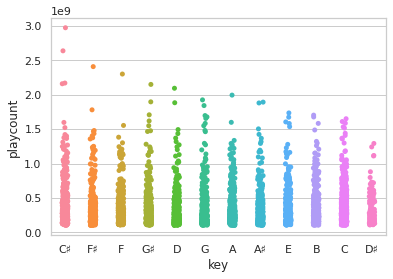

In [12]:
sns.stripplot(x="key", y="playcount", data=df)

[Text(0.5, 0, 'Key'), Text(0, 0.5, 'Youtube Views')]

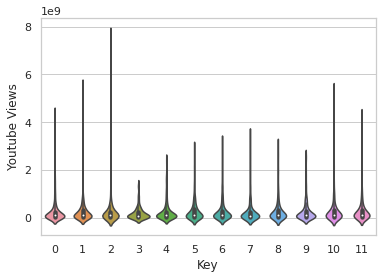

In [34]:
ax = sns.violinplot(x="key", y="view", data=df)
ax.set(xlabel='Key', ylabel='Youtube Views')

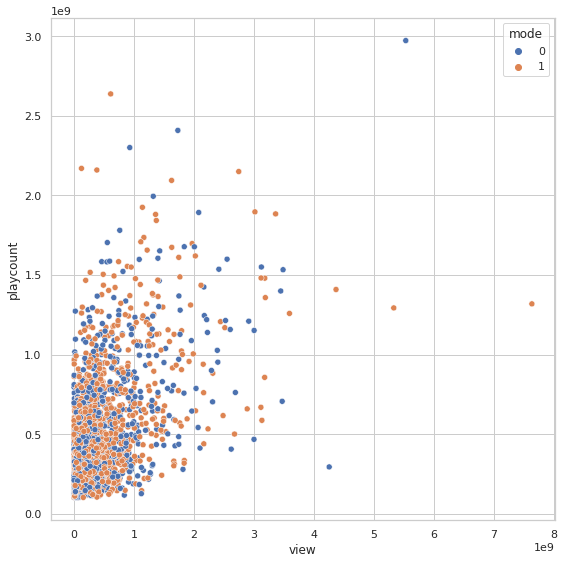

In [24]:
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='mode', ax=ax)
f.tight_layout()

### Bar plot of the counts of each categorical variable

#### Explicit

<AxesSubplot:xlabel='explicit', ylabel='count'>

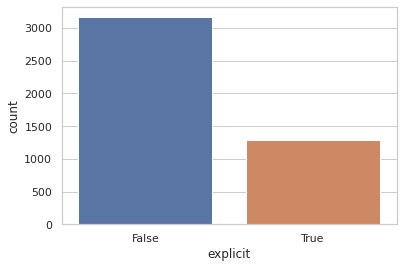

In [17]:
sns.countplot(x="explicit", data=df, order=df['explicit'].value_counts().index)

#### Key

<AxesSubplot:xlabel='key', ylabel='count'>

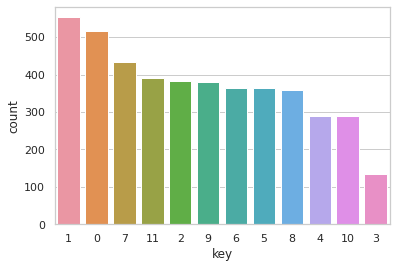

In [18]:
sns.countplot(x="key", data=df, order=df['key'].value_counts().index)

#### Time signature

<AxesSubplot:xlabel='time_signature', ylabel='count'>

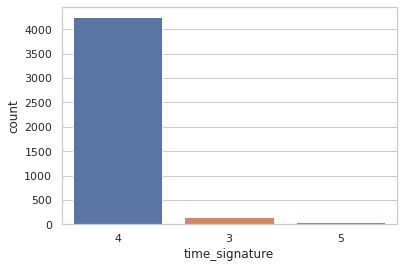

In [19]:
sns.countplot(x="time_signature", data=df, order=df['time_signature'].value_counts().index)

#### Mode

<AxesSubplot:xlabel='mode', ylabel='count'>

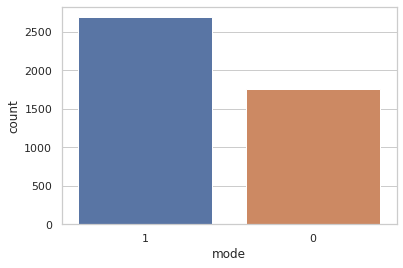

In [20]:
sns.countplot(x="mode", data=df, order=df['mode'].value_counts().index)

#### Duration

NameError: name 'stat_dict' is not defined

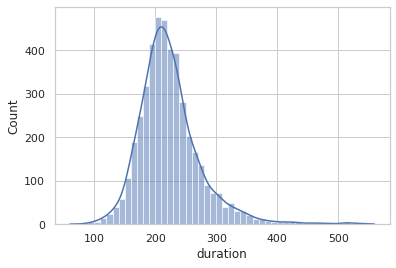

In [14]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="duration", kde=True, bins=50, ax=ax)
for j, key in enumerate(stat_dict["duration"].keys()):
    ax.text(0.7, 0.95 - j * 0.05, '{}:{}'.format(key, round(stat_dict["duration"][key], 3)), size=10, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))

### Artists with most popular songs

<AxesSubplot:xlabel='count', ylabel='artist'>

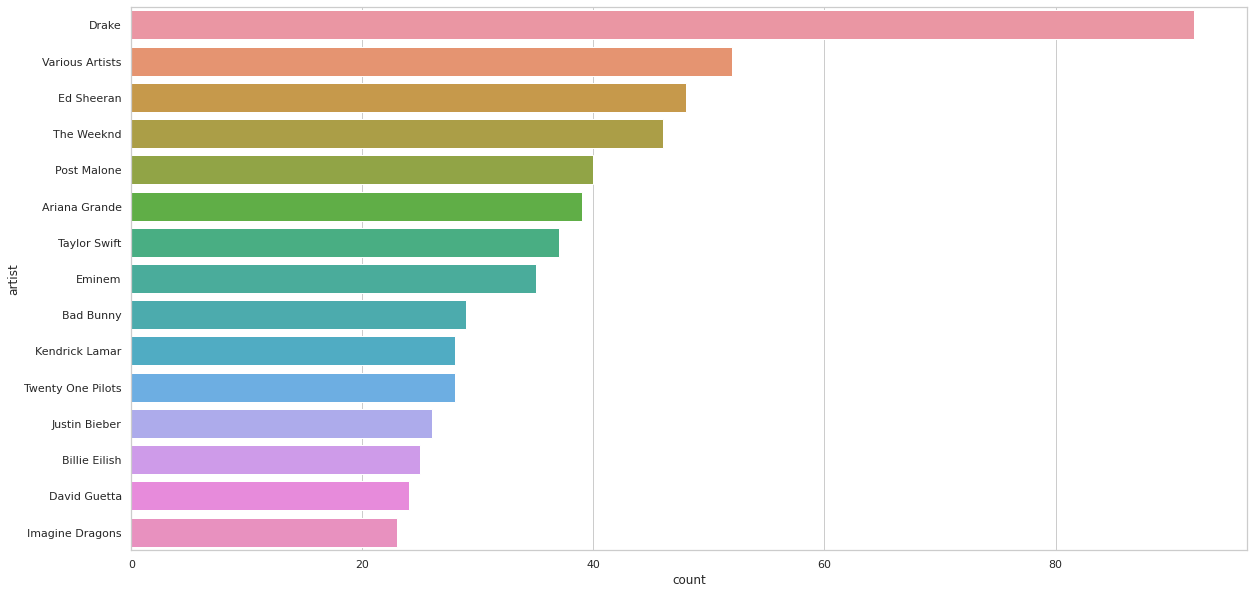

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(y="artist", data=df, order=df['artist'].value_counts().index[0:15])

### Splitting data

In [11]:
len(df[df["playcount"] < 500000000])

3591

In [12]:
len(df[df["view"] < 500000000])

3832

In [13]:
best = df[df['playcount'] > 500000000]
best = best[best['view'] > 500000000]

In [14]:
worst = pd.concat([best, df]).drop_duplicates(keep=False)

In [15]:
worst.describe

<bound method NDFrame.describe of                                             track                track_id  \
4                                       One Dance  1xznGGDReH1oQq0xzbwXa3   
10                              Someone You Loved  2TIlqbIneP0ZY1O0EzYLlc   
27                                  XO TOUR Llif3  2eMwDehkIC1j68U6FA3Eiq   
34                                     Better Now  7dt6x5M1jzdTEt8oCbisTK   
74    Light It Up (feat. Nyla & Fuse ODG) - Remix  6lDo13SSgTv0WbyUQKgnjk   
...                                           ...                     ...   
4455                                   Easy On Me  0gplL1WMoJ6iYaPgMCL0gX   
4456                              Wrong Direction  5Qsp8mtshe70DX7EYbWZGo   
4457                                 I Love You's  60todhJq1ScRkVxFvXTuZF   
4458                                Girls Like Us  5SFXOMJJ334Wn2PwBHeRZN   
4459      m y . l i f e (with 21 Savage & Morray)  1D3z6HTiQsNmZxjl7F7eoG   

                artist                   

In [16]:
df["sp_release_date"].head()

0    2017-01-06
1    2019-11-29
2    2019-08-29
3    2017-09-15
4    2016-05-06
Name: sp_release_date, dtype: object

In [17]:
df["sp_release_date"] =  pd.to_datetime(df['sp_release_date'], format='%Y-%m-%d')

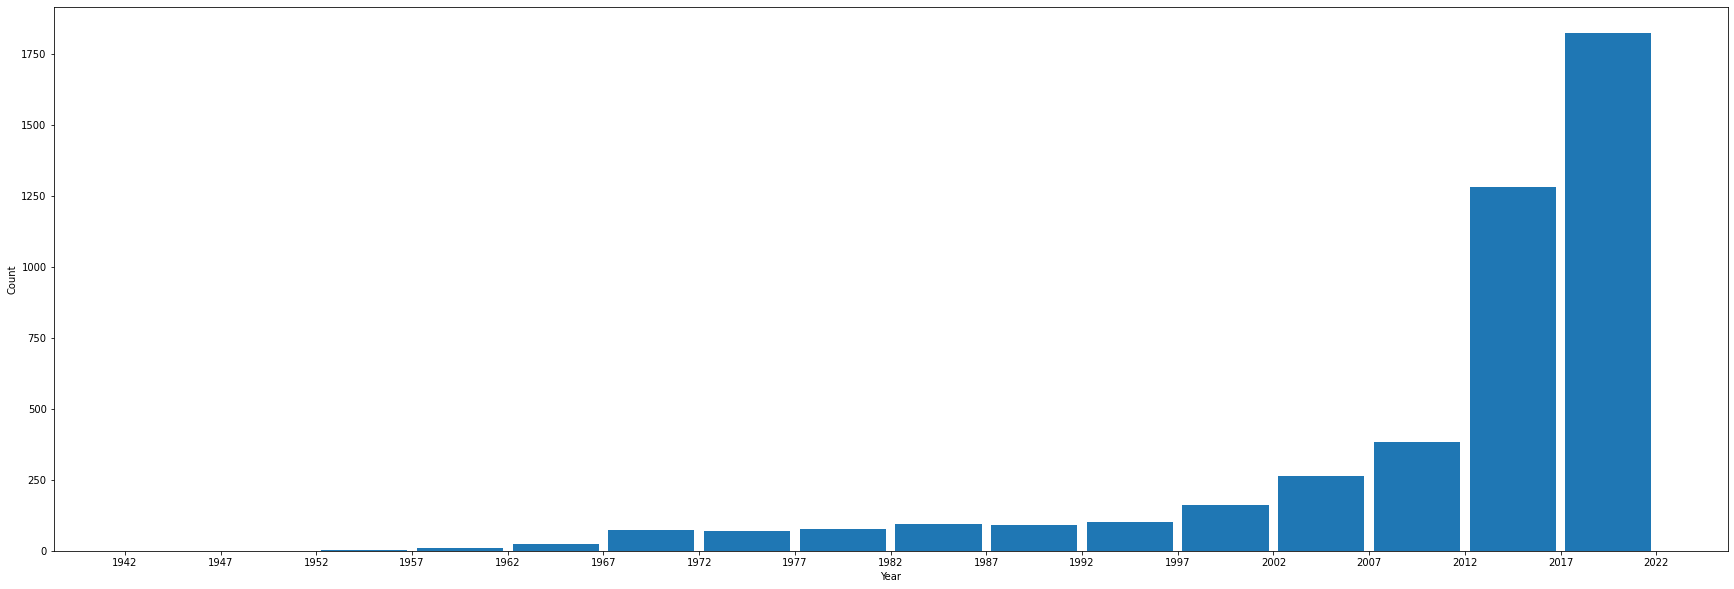

In [24]:
import numpy as np
plt.figure(figsize=(30, 10))
data = df["sp_release_date"]
data = [t.year for t in data]
number = np.arange(min(data), max(data) + 5, 5)
label = map(lambda x: str(x), number)
plt.hist(data, bins=number, rwidth=0.9)
plt.xticks(number, label)
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

In [64]:
first_chunk = df[df["sp_release_date"].apply(lambda x : x.year < 1980)]

In [68]:
second_chunk = df[df["sp_release_date"].apply(lambda x : 1980 <= x.year < 1990)]

In [71]:
third_chunk = df[df["sp_release_date"].apply(lambda x : 1990 <= x.year < 2000)]
len(third_chunk)

222

In [72]:
forth_chunk = df[df["sp_release_date"].apply(lambda x : 2000 <= x.year < 2010)]
len(forth_chunk)

521

In [74]:
forth_chunk = df[df["sp_release_date"].apply(lambda x : 2010 <= x.year < 2015)]
len(forth_chunk)

780

In [75]:
fifth_chunk = df[df["sp_release_date"].apply(lambda x : 2015 <= x.year)]
len(fifth_chunk)

2535